# Load necessary libraries

In [31]:
%matplotlib inline
# possible options: notebook, inline or widget
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import math 
import scipy.sparse as sp
import scipy.linalg as scl
from scipy.spatial import Delaunay
from scipy.sparse.linalg import splu
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6,
          'figure.dpi': 200,
          'axes.formatter.useoffset': False
          }
pylab.rcParams.update(params)

# Functions

In [32]:
# Below are a set of functions used to demonstrate accuracy of 
# the unstructured FV and its dependency on type of mesh.
#
# Ardeshir Hanifi
# Feb. 2021

    
def computeCenterMass(P = None,nodes_E = None): 
# computeCenterMass computes center of mass of each element
    
    x = P[:,0]
    y = P[:,1]
    n = len(nodes_E[0,:])
    x_cm = np.sum(x[nodes_E], 1) / n
    y_cm = np.sum(y[nodes_E], 1) / n
    return x_cm,y_cm

#-----------------------------------------------------------------------------

def computeVolume(P = None,ConnectivityList = None): 
# computeVolume computes volume of each element.
    
    NT = ConnectivityList.shape[0]
    NE = ConnectivityList.shape[1]
    eps1 = 1e-08
    volume_E = np.zeros((NT,1))
    for k in range(NT):
        ii = ConnectivityList[k,:]
        vv1 = np.array([P[ii[1],0] - P[ii[0],0], P[ii[1],1] - P[ii[0],1], 0])
        vv2 = np.array([P[ii[2],0] - P[ii[0],0], P[ii[2],1] - P[ii[0],1], 0])
        volume_E[k] = la.norm(np.cross(vv1,vv2)) * 0.5
        if NE == 4:
            vv3 = np.array([P[ii[3],0] - P[ii[0],0], P[ii[3],1] - P[ii[0],1], 0])
            volume_E[k] = volume_E[k] + la.norm(np.cross(vv3,vv2)) * 0.5
            
    nodes_E = ConnectivityList.copy()
        
    return nodes_E,volume_E

#-----------------------------------------------------------------------------

def computeVolumeDual(P = None,list_N = None,list_P = None): 
# computeVolumeDual computes volume of the dual cell surrounding each node
    
    NP = len(P)
    x = P[:,0]
    y = P[:,1]
    node_V = np.zeros((NP,1))
    for k in range(NP):
        a = list_P[k]
        node_V[k] = np.sum( np.sum( np.transpose(list_N[k])*np.array([x[a] - x[k],y[a] - y[k]]), axis=0), axis=0) * 0.25
    
    return node_V                        
#-----------------------------------------------------------------------------

def findP(P = None,nodes_E = None,list_E = None): 
# findP Finds all nodes connected to one
    
    NP = len(P)
    x = P[:,0]
    y = P[:,1]
    list_P = []
    for k in range(NP):
        a = nodes_E[list_E[k],:]
        b = np.unique(a[np.where(a!= k)]) 
        # sort the nodes
        ang = np.arctan2(y[b] - y[k], x[b] - x[k])
        ind = np.argsort(ang)
        list_P.append(b[ind])
    
    return list_P

#-----------------------------------------------------------------------------

def findT(NP = None,nodes_E = None): 
# findT Finds triangles which each node belongs to
    
    list_E=[]
    for k in range(NP):
        list_E.append(np.argwhere(nodes_E == k)[:,0])
    
    return list_E

#-----------------------------------------------------------------------------

def grad(f = None,list_P = None,list_N = None,node_V = None): 
# grad computes first derivatives of the function f
    
    NP = len(f)
    dfx = f * 0
    dfy = f * 0
    for k in range(NP):
        dfx[k] = (np.sum((f[k] + f[list_P[k]])*list_N[k][:,0]) * 0.5 / node_V[k])[0] # Added ()[0] to go from singleton array to value inside
        dfy[k] = (np.sum((f[k] + f[list_P[k]])*list_N[k][:,1]) * 0.5 / node_V[k])[0]
        # dfx[k] = np.sum((f[k] + f[list_P[k]])*list_N[k][:,0]) * 0.5 / node_V[k]
        # dfy[k] = np.sum((f[k] + f[list_P[k]])*list_N[k][:,1]) * 0.5 / node_V[k]
    return dfx,dfy

#-----------------------------------------------------------------------------

def laplace(f = None,P = None,list_N = None,list_P = None,node_V = None): 
# laplace coputes the laplcian of the function f
    
    NP = len(P)
    x = P[:,0]
    y = P[:,1]
    lapf = f * 0
    for k in range(NP):
        S = la.norm(list_N[k], axis=1)
        R = la.norm(np.array([ x[list_P[k]]-x[k] , y[list_P[k]]-y[k] ]), axis=0)
        lapf[k] = sum((f[list_P[k]] - f[k])*S / (R * node_V[k]))
    
    return lapf                       

#-----------------------------------------------------------------------------

def mshift(u = None): 
# supporting function
                      
    n = len(u)
    m = int((n - 1) / 2)
    a_s = np.zeros(n)
    a_s[np.arange(0,n+1,2)] = u[m:]
    a_s[np.arange(1,n,2)] = u[:m]
    v = np.zeros((n - 2,3) ,dtype=int)
    for k in range(n-2):
        v[k,:] = a_s[np.arange(k,k + 2 + 1)]
    
    return v
                      
#-----------------------------------------------------------------------------

def computeNormal(P = None,mcx = None,mcy = None,list_E = None,list_P = None): 
# computeNormal computes surface normals for the dual grid.
# Output: List_N{k} contains the normal vectors for each edge of dual grid surounding node k.
    
    NP = len(P)
    Px = P[:,0]
    Py = P[:,1]
    list_N = []
    for k in range(NP):
        a = list_P[k]
        xm = np.array(Px[a] + Px[k]) / 2
        ym = np.array(Py[a] + Py[k]) / 2
        s = np.zeros((len(a),2))
                           
        for m in range(len(a)-1):
            am = a[m]
            am1 = a[m + 1]
            n = np.intersect1d(np.intersect1d(list_E[am],list_E[am1]),list_E[k])
                           
            if not len(n)==0 :
                dsm  = np.transpose([mcy[n] - ym[m], xm[m] - mcx[n]])
                dsm1 = np.transpose([ym[m + 1] - mcy[n], mcx[n] - xm[m + 1]])
                v = np.transpose([Px[k] - mcx[n], Py[k] - mcy[n]])
                s[m,:] = s[m,:] - dsm * np.sign(np.inner(dsm,v))
                s[m + 1,:] = - dsm1 * np.sign(np.inner(dsm1,v))
                           
        n = np.intersect1d(np.intersect1d(list_E[a[0]],list_E[am1]),list_E[k])
                           
        if (not len(n)==0  and m >= 1):
            dsm = np.transpose([mcy[n] - ym[m + 1], xm[m + 1] - mcx[n]])
            dsm1 = np.transpose([ym[0] - mcy[n],  mcx[n] - xm[0]])
            v = np.transpose([Px[k] - mcx[n], Py[k] - mcy[n]])
            s[m + 1,:] = s[m + 1,:] - dsm * np.sign(np.inner(dsm,v))
            s[0,:] = s[0,:] - dsm1 * np.sign(np.inner(dsm1,v))
                           
        list_N.append(s)
    
    return list_N
#-----------------------------------------------------------------------------

def plotDualGrid(P = None,ConnectivityList = None,x_cm = None,y_cm = None,nodes_E = None): 
# plotDualGrid plots the dual grid
    
    plt.figure(num=300)
    plt.clf()
    plt.plot(P[:,0],P[:,1],'o')
    
    NE = len(nodes_E[0,:])
    if NE == 3:
        plt.triplot(P[:,0],P[:,1],ConnectivityList)
    else:
        for k in range(len(ConnectivityList)):
            mind=np.hstack((ConnectivityList[k,:],ConnectivityList[k,0]))
            plt.plot(P[mind,0],P[mind,1],'b-')
   
    x = np.zeros((len(nodes_E) * NE,2))
    y = np.zeros((len(nodes_E) * NE,2))
    kk = 0
    for k in range(len(nodes_E)):
        a = nodes_E[k,:]
        for m in range(NE-1):
            x[kk,:] = np.array([x_cm[k],(P[a[m],0] + P[a[m+1],0])/2])
            y[kk,:] = np.array([y_cm[k],(P[a[m],1] + P[a[m+1],1])/2])
            kk = kk + 1
        m = NE-1
        x[kk,:] = np.array([x_cm[k],(P[a[m],0] + P[a[0],0])/2])
        y[kk,:] = np.array([y_cm[k],(P[a[m],0] + P[a[0],1])/2])
        kk = kk + 1
    
    x = np.transpose(x)
    y = np.transpose(y)
    nedges = x.shape[1]
    
    for k in np.arange(0,nedges,2,dtype=int):
        plt.plot(x[k:k+1],y[k:k+1],'g-')
    x = ( np.vstack( ( x , np.full((1,nedges),np.nan), np.full((1,nedges),np.nan) ) ) ).reshape((-1,1),order='F')
    y = ( np.vstack( ( y , np.full((1,nedges),np.nan), np.full((1,nedges),np.nan) ) ) ).reshape((-1,1),order='F')
#    y = np.ma.masked_where(y < -100, y)
    plt.plot(x,y,'g-')

    plt.show()
    plt.axis('equal')
    
    return x,y

#-----------------------------------------------------------------------------
                           
def generateGrid(geocase = None,N = None): 
# generates mesh for different geometries
    
    if N < 3:
        print('**** ERROR: Value of N is too smal!')
        return P,nodes_b,nodes_in,nodes_E,volume_E,ConnectivityList
    
    Nx = N
    Ny = N
    eps1 = 1e-08
    if geocase[:5]=='squre':
        x = np.linspace(- 2,2,Nx)
        y = np.linspace(- 2,2,Ny)
        X,Y = np.meshgrid(x,y)
        NN = Nx * Ny
        X = np.reshape(np.transpose(X),(NN,1))
        Y = np.reshape(np.transpose(Y),(NN,1))
        P = np.hstack((X,Y))
                
        b1=np.arange(0,Nx* Ny,Ny)
        b2=np.arange(NN-Ny+1,NN)
        b3=np.arange((Nx-1)* Ny-1, 2*Ny-Nx, -Nx)
        b4=np.arange(Ny-1,0,- 1)
        nodes_b = np.concatenate([b1,b2,b3,b4])
        
        ConnectivityList = np.zeros(((Nx - 1) * (Ny - 1),4),dtype=int)
        if geocase[6:]=='quad':
            kk = -1
            for k in range(Ny-1):
                for m in range(Nx-1):
                    mm = k * Ny + m
                    kk = kk + 1
                    ConnectivityList[kk,:] = (np.array([mm,mm + Ny,mm + Ny + 1,mm + 1]))
        else:
            DT = Delaunay(P)
            ConnectivityList = DT.simplices
    elif geocase[:8]=='triangle':
        km = 0
        kn = 0
        P = np.zeros((int(N*(N + 1)/2),2))
        ConnectivityList = np.zeros(((N - 1) * (N - 1),3),dtype=int)
        P[0,:]=([0.0,0.0])
        for k in range(1,N):
            for m in range(k+1):
                y = float(k)
                x = 2*m -k
                km = km + 1
                P[km,:] = np.array([x,y])
                
            mind=mshift( np.arange(km-2*k,km+1) )
            ConnectivityList[kn:kn+mind.shape[0],:]=mind 
            kn=kn+mind.shape[0]
                            
        P = P / P[-1,1]
        b1=np.where(P[:,0] < -P[:,1] + eps1)
        b2=np.where(P[:,0] > P[:,1] - eps1)
        b3=np.where(P[:,1] > 1 - eps1)
        nodes_b = np.unique(np.concatenate((b1,b2,b3),axis=1))
        if geocase[9:]=='random':
            DT = Delaunay(P)
            ConnectivityList = DT.simplices
    else:
        print('**** ERROR: No valid value for parameter geocase!')
        return

        
    nodes_in = np.setdiff1d(np.arange(len(P)),nodes_b)

    # compute volumes of each triangle and remove those with zero volume
    nodes_E,volume_E = computeVolume(P,ConnectivityList)
    print('      Total no. points NP= ',P.shape[0])
    print('      Total no. cells  NC= ',nodes_E.shape[0])
    
    return P,nodes_b,nodes_in,nodes_E,volume_E,ConnectivityList
                      
#-----------------------------------------------------------------------------
                               
def setf(P = None): 
# setf computes values of the test function and its analytic
# derivatives to be used for comparison
    
    x = P[:,0]
    y = P[:,1]
    pi= np.pi
    f = np.sin(x * pi)*np.cos(y * pi)
    dfxa = pi * np.cos(x * pi)*np.cos(y * pi)
    dfya = - pi * np.sin(x * pi)*np.sin(y * pi)
    ddfa = - 2 * pi * pi * f
    return f,dfxa,dfya,ddfa  

#-----------------------------------------------------------------------------
                                 
def setf_const(P = None): 
# setf computes values of the test function and its analytic
# derivatives to be used for comparison
    
    x = P[:,0]
    y = P[:,1]
    f = x * 0 + 1
    dfxa = 0 * x
    dfya = 0 * x
    ddfa = 0 * x
    return f,dfxa,dfya,ddfa
      
#-----------------------------------------------------------------------------
                           
def setf_linear(P = None): 
# setf computes values of the test function and its analytic
# derivatives to be used for comparison
    
    x = P[:,0]
    y = P[:,1]
    f = 2 * x + 5 * y
    dfxa = 0 * x + 2
    dfya = 0 * x + 5
    ddfa = 0 * x
    return f,dfxa,dfya,ddfa
#-----------------------------------------------------------------------------

def plotGrid(P = None, ConnectivityList = None, PlotNr = None): 
# plot the grid

    plt.figure(num=int(PlotNr))
    #plt.clf()
    if geocase=='squre_quad':
        
        for k in range(len(ConnectivityList)):
            mind=np.hstack((ConnectivityList[k,:],ConnectivityList[k,0]))
            plt.plot(P[mind,0],P[mind,1],'b-',linewidth=0.5)
    else:
        plt.triplot(P[:,0],P[:,1],ConnectivityList,linewidth=0.5)

    plt.plot(P[nodes_b,0],P[nodes_b,1],'r*')
    plt.show()
    
    return

# Task 1

      Total no. points NP=  400
      Total no. cells  NC=  361


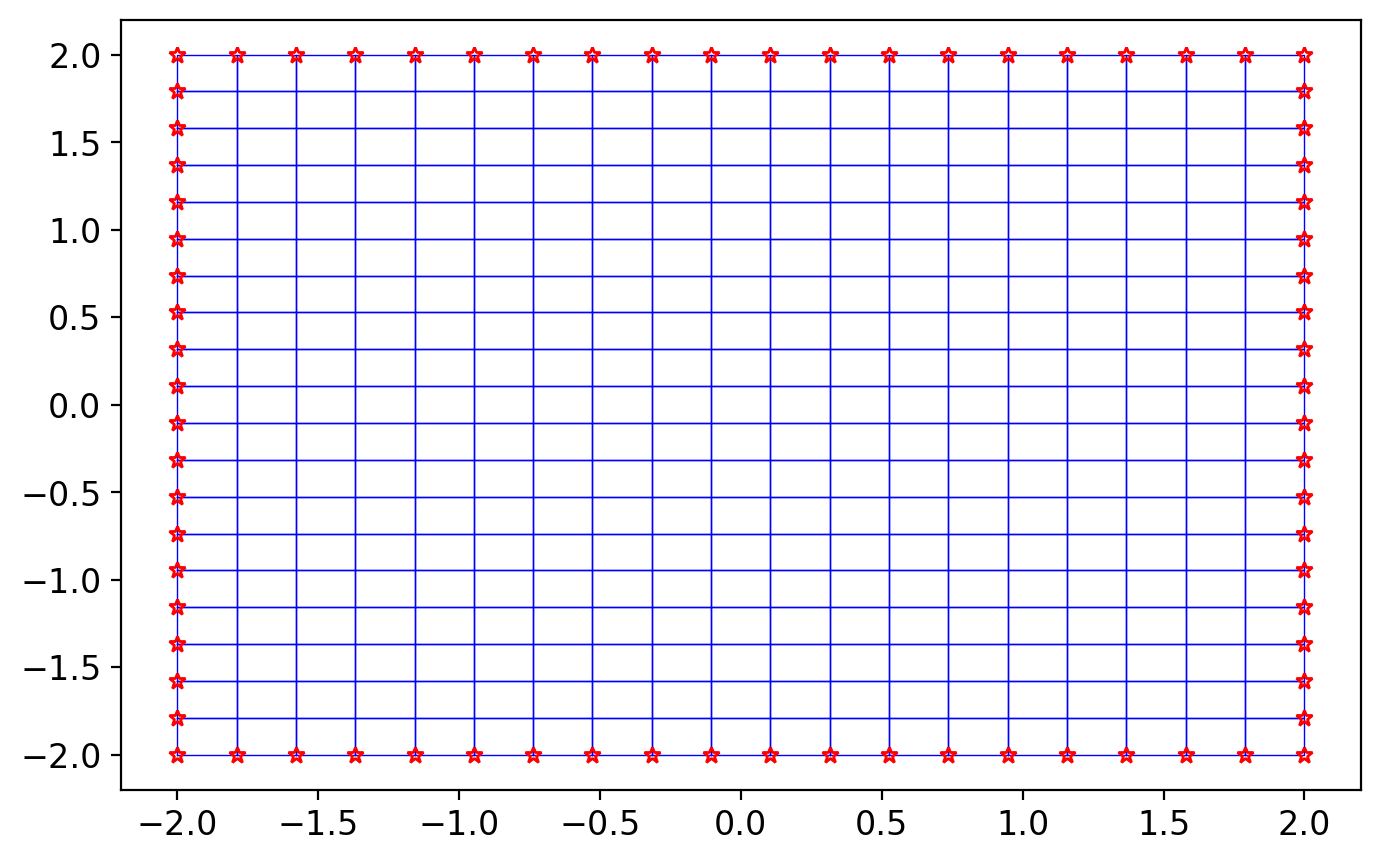

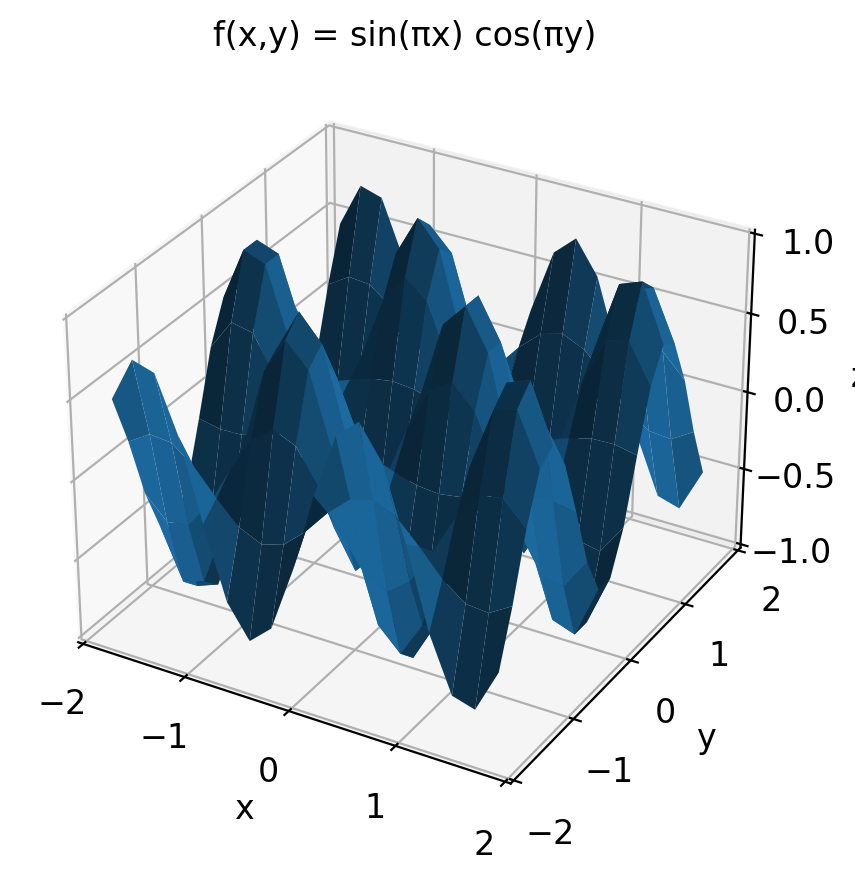

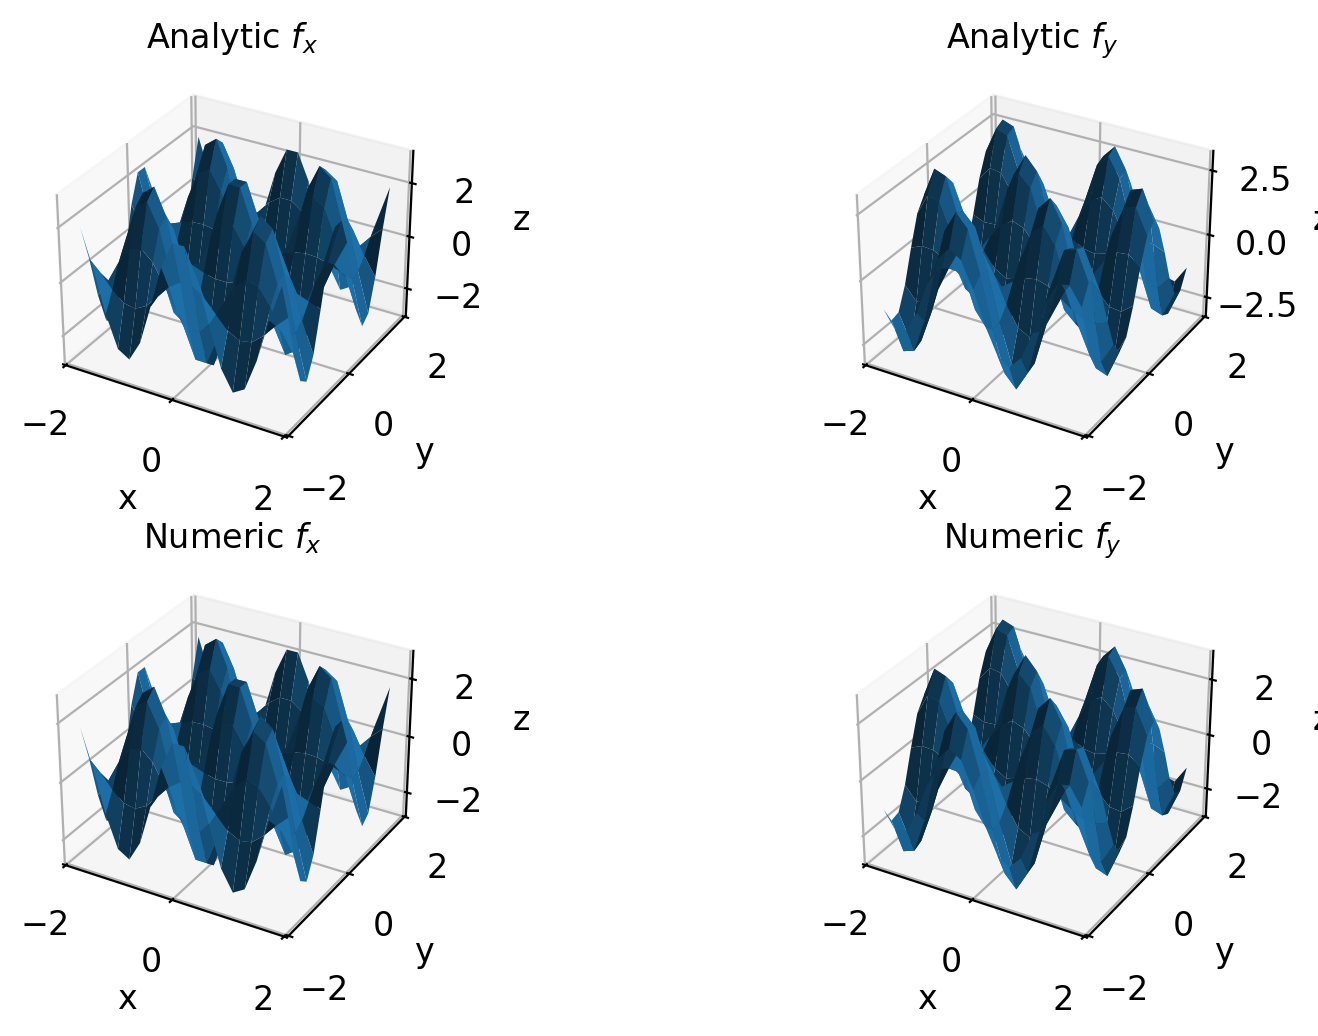

In [39]:
# Choose geometry either 'squre_quad' or 'squre_tri' 'triangle' or 'triangle_random'
geocase='squre_quad'

# Choose the number of points N to 20
N = 20

# Create the grid
[P,nodes_b,nodes_in,nodes_E,volume_E,ConnectivityList] = generateGrid(geocase,N)

plotGrid(P, ConnectivityList, N)

NP=len(P) # Total number of points

[x_cm, y_cm] = computeCenterMass(P,nodes_E)
    
# Find elements which each node belongs to
list_E = findT(NP,nodes_E)

# Find all nodes connected to one
list_P = findP(P,nodes_E,list_E)

# compute normals of dual grid
list_N = computeNormal(P,x_cm,y_cm,list_E,list_P)

# compute volume of the dual grid cells
node_V = computeVolumeDual(P,list_N,list_P)

# Set the function (a. constant, b. linear, c. waves)
# [f,dfxa,dfya,lapfa] = setf_const(P)
# f_string = '1'
# [f,dfxa,dfya,lapfa] = setf_linear(P)
# f_string = '2x + 5y'
[f,dfxa,dfya,lapfa] = setf(P)
f_string = 'sin(πx) cos(πy)'

# compute first derivative at all nodes
dfx,dfy = grad(f,list_P,list_N,node_V)

# Prep for plotting
fig_f = plt.figure() # This is a plot of the function f(x,y)
ax_f = fig_f.add_subplot(1,1,1,projection='3d', title = f"f(x,y) = {f_string}", xlabel='x', ylabel='y', zlabel='z')


fig_task1 = plt.figure(constrained_layout=True)
ax1 = fig_task1.add_subplot(2, 2, 1, projection='3d', title=f"Analytic $f_x$", xlabel='x', ylabel='y', zlabel='z')
ax2 = fig_task1.add_subplot(2, 2, 2, projection='3d', title=f"Analytic $f_y$", xlabel='x', ylabel='y', zlabel='z')
ax3 = fig_task1.add_subplot(2, 2, 3, projection='3d', title=f"Numeric $f_x$", xlabel='x', ylabel='y', zlabel='z')
ax4 = fig_task1.add_subplot(2, 2, 4, projection='3d', title=f"Numeric $f_y$", xlabel='x', ylabel='y', zlabel='z')
# fig_task1.tight_layout()

if geocase == "squre_quad":
    x = P[nodes_in,0].reshape((N-2, -1))
    y = P[nodes_in,1].reshape((N-2, -1))

    ax_f.plot_surface(x , y, f[nodes_in].reshape((N-2,-1)))

    ax1.plot_surface(x, y, dfxa[nodes_in].reshape((N-2,-1)))
    ax2.plot_surface(x, y, dfya[nodes_in].reshape((N-2,-1)))
    ax3.plot_surface(x, y, dfx[nodes_in].reshape((N-2,-1)))
    ax4.plot_surface(x, y, dfy[nodes_in].reshape((N-2,-1)))
else:
    x = P[nodes_in,0]
    y = P[nodes_in,1]
    ax_f.plot_trisurf(x,y,f[nodes_in])
    ax1.plot_trisurf(x, y, dfxa[nodes_in])
    ax2.plot_trisurf(x, y, dfya[nodes_in])
    ax3.plot_trisurf(x, y, dfx[nodes_in])
    ax4.plot_trisurf(x, y, dfy[nodes_in])



# Run cases

In [34]:
# Choose geometry either 'squre_quad' or 'squre_tri' 'triangle' or 'triangle_random'
geocase='triangle'

# size of grids to be examined
NN=([10,20,40,80,100])

nn=-1
ndim=np.zeros((len(NN),1))
errx=np.zeros((len(NN),1))
erry=np.zeros((len(NN),1))
errl=np.zeros((len(NN),1))
errln=np.zeros((len(NN),1))

for N in NN:
    
    print('Runing the case for N= ', N)
    
    # set up the grid and copmute related data set
    [P,nodes_b,nodes_in,nodes_E,volume_E,ConnectivityList]=generateGrid(geocase,N)
    
    NP=len(P)
    
    # center of mass
    [x_cm, y_cm] = computeCenterMass(P,nodes_E)
    
    # Find elements which each node belongs to
    list_E = findT(NP,nodes_E)
    
    # Find all nodes connected to one
    list_P = findP(P,nodes_E,list_E)
    
    # compute normals of dual grid
    list_N = computeNormal(P,x_cm,y_cm,list_E,list_P)
    
    # compute volume of the dual grid cells
    node_V = computeVolumeDual(P,list_N,list_P)
    
    # set up function and its analytical derivatives
    [f,dfxa,dfya,lapfa] = setf(P)
    
    # compute first derivative at all nodes
    dfx,dfy = grad(f,list_P,list_N,node_V)
    
    # compute Laplca at all nodes
    lapf = laplace(f,P,list_N,list_P,node_V)
    
    # compute second derivative at all nodes by applying first derivative two times 
    ddfxx, ddfxy = grad(dfx,list_P,list_N,node_V)
    ddfyx, ddfyy = grad(dfy,list_P,list_N,node_V)
    lapfn = ddfxx + ddfyy
    
    # plotGrid(P, ConnectivityList, N)
    
    # compute errors
    nn=nn+1
    ndim[nn]=np.sqrt(NP)
    
    errx[nn]= np.linalg.norm(dfxa[nodes_in]-dfx[nodes_in])/np.linalg.norm(dfxa[nodes_in])
    erry[nn]= np.linalg.norm(dfya[nodes_in]-dfy[nodes_in])/np.linalg.norm(dfya[nodes_in])
    errl[nn]= np.linalg.norm(lapfa[nodes_in]-lapf[nodes_in])/np.linalg.norm(lapfa[nodes_in])
    errln[nn]= np.linalg.norm(lapfa[nodes_in]-lapfn[nodes_in])/np.linalg.norm(lapfa[nodes_in])

# fig_err, ax_err = plt.subplots()
# ax_err.plot(NN, errx, label='$f_x$')
# ax_err.plot(NN, erry, label='$f_y$')
# ax_err.plot(NN, errl, label='laplacian')
# ax_err.plot(NN, errln, label='double grad')



Runing the case for N=  10
      Total no. points NP=  55
      Total no. cells  NC=  81
Runing the case for N=  20
      Total no. points NP=  210
      Total no. cells  NC=  361
Runing the case for N=  40
      Total no. points NP=  820
      Total no. cells  NC=  1521
Runing the case for N=  80
      Total no. points NP=  3240
      Total no. cells  NC=  6241
Runing the case for N=  100
      Total no. points NP=  5050
      Total no. cells  NC=  9801


# Plot data

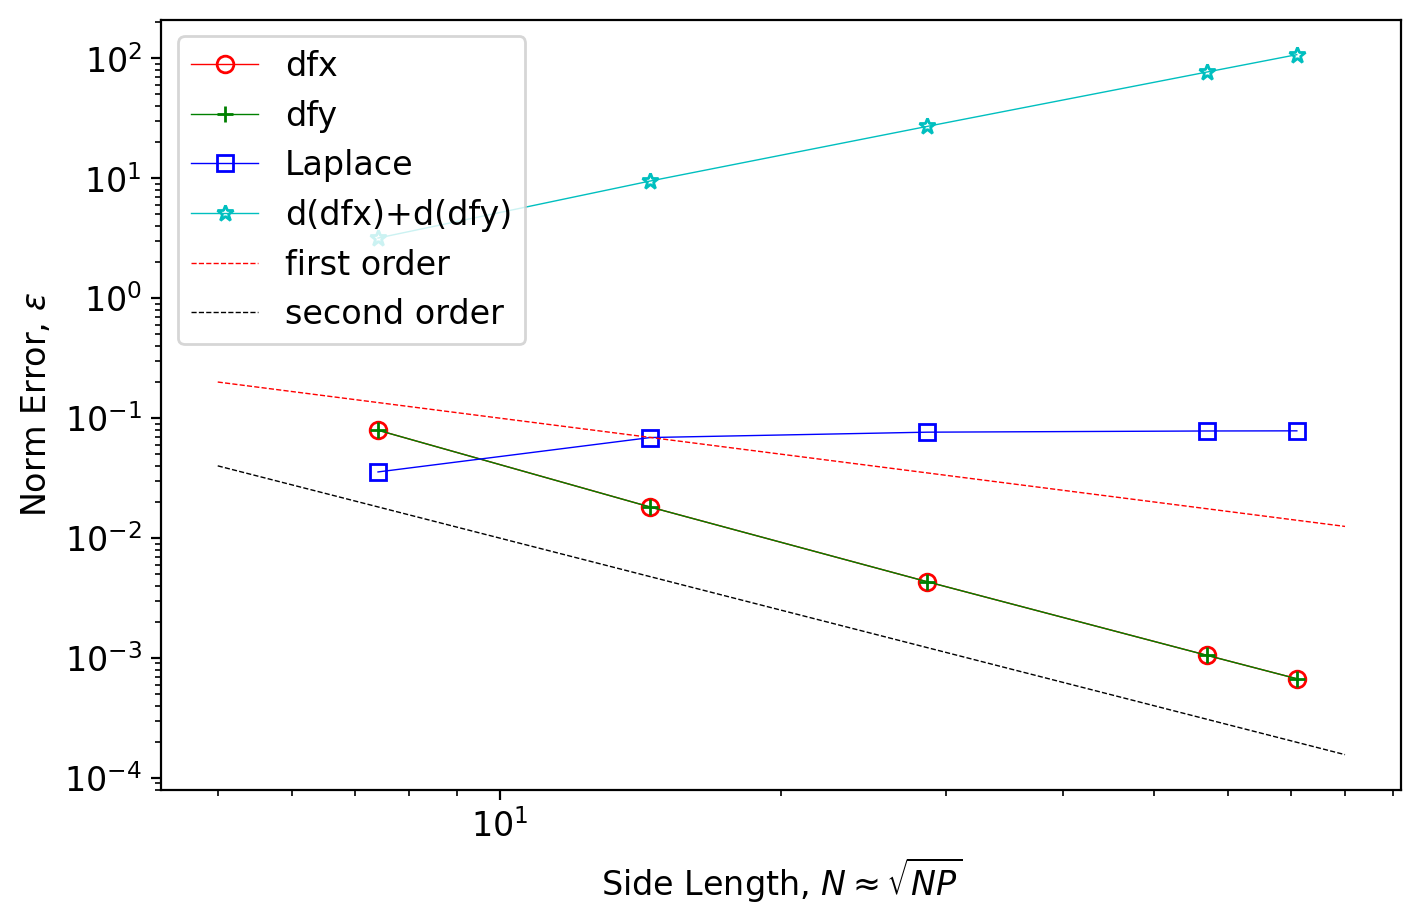

In [35]:
# plot error convergence

plt.figure(num=111)
plt.loglog(ndim,errx,'ro-',\
    ndim,erry,'g+-',\
    ndim,errl,'bs-',\
    ndim,errln,'c*-',\
    [5,80],np.power([5,80],-1.0),'r--', [5,80],np.power([5,80],-2.0),'k--',linewidth=0.5)
plt.gca().legend(('dfx','dfy','Laplace','d(dfx)+d(dfy)','first order','second order'))
plt.xlabel(r'Side Length, $N \approx \sqrt{NP}$')
plt.ylabel(r'Norm Error, $\varepsilon$')
plt.show()
